In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# import seaborn as sns

from sklearn.model_selection import train_test_split as TTS,  GridSearchCV  
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB as NB


import nltk
from nltk.corpus import stopwords, sentiwordnet, wordnet
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

import spacy

from typing import List
from pprint import pprint


import gensim
from gensim.utils import simple_preprocess
import gensim.corpora as corpora
from gensim.models import CoherenceModel
import pyLDAvis.gensim

import tqdm

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping


import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
import warnings
warnings.filterwarnings("ignore")

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\marcu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# EDA
### PREPROCESSING

In [9]:
lotr = pd.read_csv("lotr_scripts.csv")
lotr.head()

,Unnamed: 0,char,dialog,movie
0,0,DEAGOL,"Oh Smeagol Ive got one! , Ive got a fish Smeag...",The Return of the King
1,1,SMEAGOL,"Pull it in! Go on, go on, go on, pull it in!",The Return of the King
2,2,DEAGOL,Arrghh!,The Return of the King
3,3,SMEAGOL,Deagol!,The Return of the King
4,4,SMEAGOL,Deagol!,The Return of the King


In [ ]:
lotr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2390 entries, 0 to 2389
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  2390 non-null   int64 
 1   char        2390 non-null   object
 2   dialog      2389 non-null   object
 3   movie       2390 non-null   object
dtypes: int64(1), object(3)
memory usage: 74.8+ KB


In [ ]:
# Spotting inconcistencies with naming
lotr.char.unique()

array(['DEAGOL', 'SMEAGOL', '(GOLLUM', 'FRODO', 'MERRY', 'GIMLI',
       'GOLLUM', 'SAM', 'GANDALF', 'ARAGORN', 'PIPPIN', 'HOBBIT', 'ROSIE',
       'BILBO', 'TREEBEARD', 'SARUMAN', 'THEODEN', 'GALADRIL', 'ELROND',
       'GRIMA', 'FRODO VOICE OVER', 'WITCH KING', 'EOWYN', 'FARAMIR',
       'ORC', '\xa0GANDALF', 'SOLDIERS ON GATE', 'GOTHMOG', 'GENERAL',
       'CAPTAIN', 'SOLDIER', 'MOUTH OF SAURON', 'EOMER', 'ARMY', 'BOSON',
       'MERCENARY', 'EOWYN/MERRY', 'DENETHOR', 'ROHIRRIM',
       'GALADRIEL VOICEOVER', 'LEGOLAS', 'GALADRIEL', 'KING OF THE DEAD',
       'GRIMBOLD', 'IROLAS', 'ORCS', 'GAMLING', 'MADRIL', 'DAMROD',
       'SOLDIERS', 'SOLDIERS IN MINAS TIRITH', 'GANDALF VOICEOVER',
       'SOLDIER 1', 'SOLDIER 2', 'WOMAN', 'HALDIR', 'SAM VOICEOVER',
       'OLD MAN', 'BOROMIR', 'CROWD', 'ARWEN', 'ELROND VOICEOVER',
       'ARWEN VOICEOVER', 'ARAGORN ', 'HAMA', 'SHARKU', 'PEOPLE', 'LADY',
       'FREDA', 'MORWEN', 'EYE OF SAURON', 'ROHAN STABLEMAN', 'GORBAG',
       'ARGORN', 'GA

In [10]:
flaws = list(["(GOLLUM", "GALADRIL", "FRODO VOICE OVER", "\xa0GANDALF", "MOUTH OF SAURON", "GALADRIEL VOICEOVER", "GANDALF VOICEOVER", 
         "SAM VOICEOVER", "ELROND VOICEOVER", "ARWEN VOICEOVER", "ARAGORN ", "ARGORN", "GANDALF VOICE OVER", "SARUMAN VOICE OVER", 
         "SARUMAN VOICE OVER ", "URUK-HAI" "FRODO ", "GALADRIEL VOICE-OVER", "SAURON VOICE", "SAM ", "FRODO VOICE", 
         "GALADRIEL VOICE OVER", "SARUMAN VOICEOVER", "BILBO VOICEOVER", "GATEKEEPR", "GAN DALF"])

correct = list(["GOLLUM", "GALADRIEL", "FRODO", "GANDALF","SAURON", "GALADRIEL", "GANDALF", "SAM", "ELROND", "ARWEN", "ARAGORN", "ARAGORN", 
                "GANDALF", "SARUMAN", "SARUMAN", "URUK HAI", "FRODO", "GALADRIEL", "SAURON", "SAM", "FRODO", "GALADRIEL", "SARUMAN", 
                "BILBO", "GATEKEEPER", "GANDALF"])

for i in range(len(flaws)):
    lotr.loc[lotr["char"] == flaws[i], "char"] = correct[i]
lotr.char.unique()


array(['DEAGOL', 'SMEAGOL', 'GOLLUM', 'FRODO', 'MERRY', 'GIMLI', 'SAM',
       'GANDALF', 'ARAGORN', 'PIPPIN', 'HOBBIT', 'ROSIE', 'BILBO',
       'TREEBEARD', 'SARUMAN', 'THEODEN', 'GALADRIEL', 'ELROND', 'GRIMA',
       'WITCH KING', 'EOWYN', 'FARAMIR', 'ORC', 'SOLDIERS ON GATE',
       'GOTHMOG', 'GENERAL', 'CAPTAIN', 'SOLDIER', 'SAURON', 'EOMER',
       'ARMY', 'BOSON', 'MERCENARY', 'EOWYN/MERRY', 'DENETHOR',
       'ROHIRRIM', 'LEGOLAS', 'KING OF THE DEAD', 'GRIMBOLD', 'IROLAS',
       'ORCS', 'GAMLING', 'MADRIL', 'DAMROD', 'SOLDIERS',
       'SOLDIERS IN MINAS TIRITH', 'SOLDIER 1', 'SOLDIER 2', 'WOMAN',
       'HALDIR', 'OLD MAN', 'BOROMIR', 'CROWD', 'ARWEN', 'HAMA', 'SHARKU',
       'PEOPLE', 'LADY', 'FREDA', 'MORWEN', 'EYE OF SAURON',
       'ROHAN STABLEMAN', 'GORBAG', 'BOROMIR ', 'UGLUK', 'SHAGRAT',
       'FRODO ', 'URUK-HAI', 'SNAGA', 'GRISHNAKH', 'MERRY and PIPPIN',
       'WILDMAN', 'STRIDER', 'EOTHAIN', 'ROHAN HORSEMAN', 'FARMER MAGGOT',
       'WHITE WIZARD', 'MERRY AND P

In [11]:
lotr = lotr.dropna(axis=0)
lotr = lotr.drop(["Unnamed: 0", "movie"], axis=1)
lotr.head()

,char,dialog
0,DEAGOL,"Oh Smeagol Ive got one! , Ive got a fish Smeag..."
1,SMEAGOL,"Pull it in! Go on, go on, go on, pull it in!"
2,DEAGOL,Arrghh!
3,SMEAGOL,Deagol!
4,SMEAGOL,Deagol!


In [12]:

lotr_train, lotr_test = TTS(lotr, test_size=0.3, random_state=42)
lotr_train.reset_index(drop=True, inplace=True)
lotr_test.reset_index(drop=True, inplace=True)

### Initial EDA

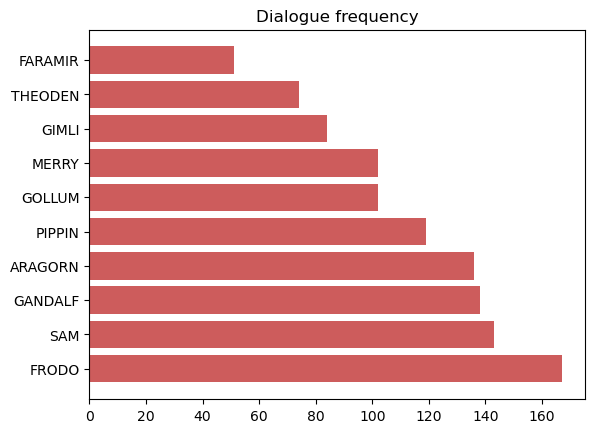

In [ ]:
# Plotting dialouge frequnecy
char_freq = lotr_train.groupby("char").size().reset_index(name="freq")
char_freq = char_freq.sort_values(by="freq",ascending=False)
plt.barh(char_freq.char[:10], char_freq.freq[:10], color="indianred")
plt.title("Dialogue frequency")
plt.show()


### SIMPLE FEATURE ENGENERING

In [ ]:
stopwords_set = set(stopwords.words("english"))
nlp = spacy.load("en_core_web_sm")

def simple_features(data: pd.DataFrame):
    # dialog lengths
    data["word_len"] = data.dialog.apply(lambda x: len(x.split()))
    data["character_len"] = data.dialog.apply(lambda x: len(x))
    # Stopword count
    data["stopword_count"] = data.dialog.apply(lambda x: sum(1 for word in x.split() if word.lower() in stopwords_set))
    # Word frequency by POS Tag
    data['verb_count'] = data['dialog'].apply(count_verbs)
    data['adj_count'] = data['dialog'].apply(count_adjectives)
    data['propn_count'] = data['dialog'].apply(count_proper_noun)
    # Uniqe word counter
    data['uinque_words'] = data['dialog'].apply(unique_words)

    return data

def count_verbs(text):
    doc = nlp(text)
    return sum(1 for token in doc if token.pos_ == "VERB")

def count_adjectives(text):
    doc = nlp(text)
    return sum(1 for token in doc if token.pos_ == "ADJ")

def count_proper_noun(text):
    doc = nlp(text)
    return sum(1 for token in doc if token.pos_ == "PROPN")

def unique_words(text):
    return len(set(text.split()))

lotr_train = simple_features(lotr_train)
lotr_test = simple_features(lotr_test)

# Ideeas for more #################
# avg. word length
# unique word ratio

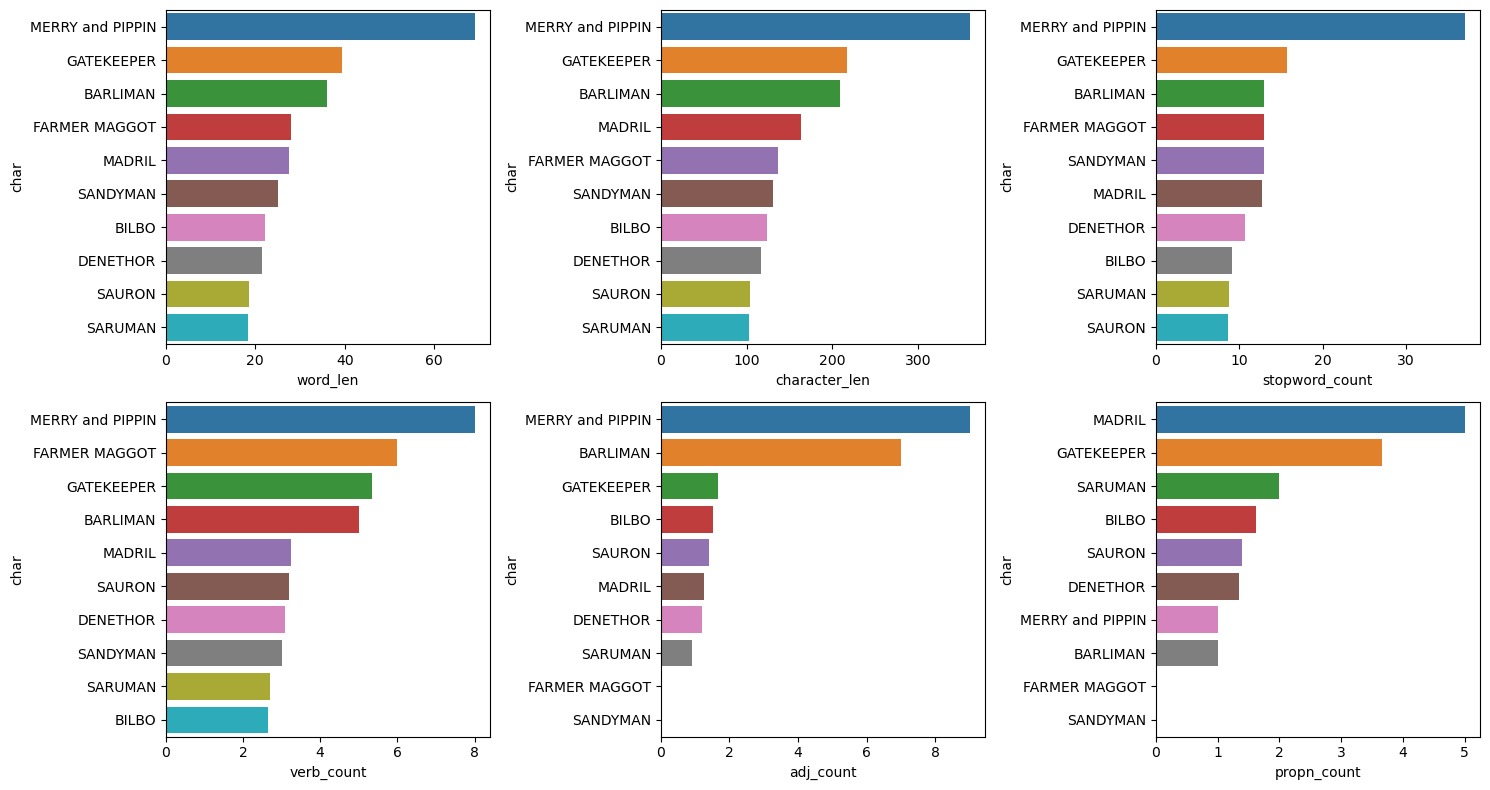

In [ ]:
# Plotting dialouge frequnecy
char_var = lotr_train.groupby("char")[["word_len", "character_len", "stopword_count", "verb_count", "adj_count", "propn_count"]].mean().reset_index()
#char_var = char_var.sort_values(by="freq",ascending=False)

plt.figure(figsize = (15, 8))
plt.tight_layout()
plt.subplot(2, 3, 1)
char_var = char_var.sort_values(by="word_len", ascending=False)[:10]
sns.barplot(x=char_var.word_len, y=char_var.char)
plt.subplot(2, 3, 2)
char_var = char_var.sort_values(by="character_len", ascending=False)[:10]
sns.barplot(x=char_var.character_len, y=char_var.char)
plt.subplot(2, 3, 3)
char_var = char_var.sort_values(by="stopword_count", ascending=False)[:10]
sns.barplot(x=char_var.stopword_count, y=char_var.char)
plt.subplot(2, 3, 4)
char_var = char_var.sort_values(by="verb_count", ascending=False)[:10]
sns.barplot(x=char_var.verb_count, y=char_var.char)
plt.subplot(2, 3, 5)
char_var = char_var.sort_values(by="adj_count", ascending=False)[:10]
sns.barplot(x=char_var.adj_count, y=char_var.char)
plt.subplot(2, 3, 6)
char_var = char_var.sort_values(by="propn_count", ascending=False)[:10]
sns.barplot(x=char_var.propn_count, y=char_var.char)
plt.tight_layout()
plt.show()


### SENTIMENT ANALYSIS

In [ ]:
# Dialog sentiment

def word_sentiment_score(word: str) -> float:
    synsets = list(sentiwordnet.senti_synsets(word))
    if synsets:
        sentiment = synsets[0]
        return sentiment.pos_score() - sentiment.neg_score()
    else:
        return 0.0  

def sentence_sentiment(sentence):
    sent = nlp(sentence)
    sent_sentiment = sum(word_sentiment_score(token.text) for token in sent)
    return sent_sentiment

def dialog_sentiment(data):
    data['dialog_sentiment'] = data['dialog'].apply(sentence_sentiment)
    return data

lotr_train = dialog_sentiment(lotr_train)
lotr_test = dialog_sentiment(lotr_test)

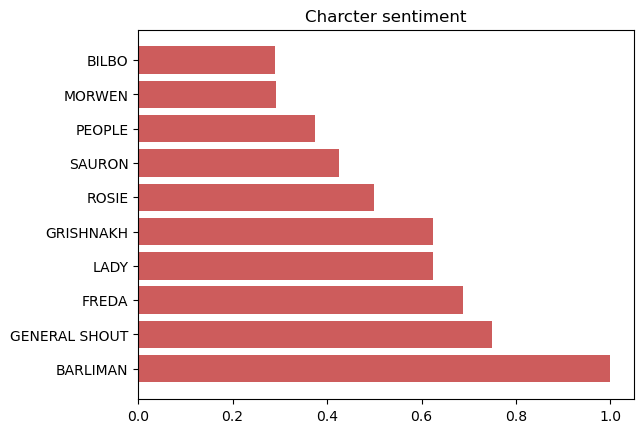

In [ ]:
# Plotting dialouge frequnecy
char_sent = lotr_train.groupby("char")["dialog_sentiment"].mean().reset_index()
char_sent = char_sent.sort_values(by="dialog_sentiment", ascending=False)
plt.barh(char_sent.char[:10], char_sent.dialog_sentiment[:10], color="indianred")
plt.title("Charcter sentiment")
plt.show()

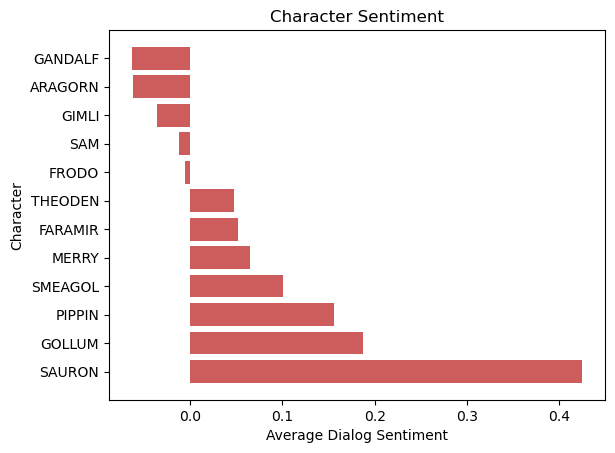

In [ ]:
imp_char = ["FRODO", "SAM", "GANDALF", "PIPPIN", "MERRY", "GOLLUM", "GIMLI", "THEODEN", "FARAMIR", "SAURON", "ARAGORN", "SMEAGOL"]
# Plotting dialouge frequnecy
char_sent = lotr_train.groupby("char")["dialog_sentiment"].mean().reset_index()
char_sent = char_sent.sort_values(by="dialog_sentiment", ascending=False)
char_sent_filtered = char_sent[char_sent['char'].isin(imp_char)]
plt.barh(char_sent_filtered['char'], char_sent_filtered['dialog_sentiment'], color="indianred")
plt.title("Character Sentiment")
plt.xlabel("Average Dialog Sentiment")
plt.ylabel("Character")
plt.show()

### LDA - Topic Analysis

In [13]:
# Topic modelling using LDA

stemmer = SnowballStemmer("english")


def stem(text):
    return stemmer.stem(text)

def preprocess_for_topic(document: str) -> List[str]:

    #tokenized = nlp(document)

    preprocessed = []
    for token in gensim.utils.simple_preprocess(document, min_len=4):
        if token not in stopwords_set: #and len(token) > 3:
            preprocessed.append(stem(token.lower()))
    return preprocessed


def create_bow_corp(data):
    preprocessed = []
    [preprocessed.append(preprocess_for_topic(dialog)) for dialog in data.dialog]
    dic = corpora.Dictionary(preprocessed)
    bow_corpus = [dic.doc2bow(doc) for doc in preprocessed]
    return preprocessed, dic, bow_corpus

preprocessed_train, dic_train, bow_corpus_train = create_bow_corp(lotr_train)
preprocessed_test, dic_test, bow_corpus_test = create_bow_corp(lotr_test)


lda_model = gensim.models.LdaMulticore(bow_corpus_train, num_topics = 3, id2word = dic_train, passes = 10, workers = 2, random_state=42)
lda_model.show_topics()

NameError: name 'stopwords_set' is not defined

In [ ]:
# Extract top contributing words for each topic
top_words_per_topic = []
for topic_id in range(lda_model.num_topics):
    topic_words = lda_model.show_topic(topic_id, topn=5)
    top_words = [word for word, _ in topic_words]
    top_words_per_topic.append(top_words)


for i, words in enumerate(top_words_per_topic):
    print(f"Topic {i}: {', '.join(words)}")

Topic 0: gondor, aragorn, good, nice, leav
Topic 1: come, master, lord, would, must
Topic 2: frodo, gandalf, merri, know, back


In [ ]:
# Classifying the dialogs to their respective topics
predictions = lda_model[bow_corpus_train]
topic_list = []

for i, pred in enumerate(predictions[:5]):
    max_prob_topic = max(pred, key=lambda x: x[1])
    topic_list.append(max_prob_topic)
    topic_num, prob = max_prob_topic
    topic_keywords = ", ".join([word for word, _ in lda_model.show_topic(topic_num)])
    print(f"Review {i}:")
    print(f"Review body: {lotr_train.dialog[i]}")
    print(f"Predicted Topic: {topic_num}, Confidence: {prob:.4f}")

Review 0:
Review body: Grond, Grond, Grond, Grond!  
Predicted Topic: 0, Confidence: 0.8666
Review 1:
Review body: Smeagol?  
Predicted Topic: 2, Confidence: 0.6630
Review 2:
Review body: Look!The gate.It's opening!I can see a way down. 
Predicted Topic: 2, Confidence: 0.6577
Review 3:
Review body: Well, that's good news. 
Predicted Topic: 2, Confidence: 0.8119
Review 4:
Review body:     Frodo. 
Predicted Topic: 2, Confidence: 0.6614


In [ ]:
# supporting function
def compute_coherence_values(corpus, dictionary, k):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=42,
                                           chunksize=100,
                                           passes=10,)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=preprocessed_train, dictionary=dic_train, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [ ]:

grid = {}
grid['Validation_Set'] = {}

# Topics range
min_topics = 3
max_topics = 11
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# Validation sets
num_of_docs = len(bow_corpus_train)
corpus_sets = [gensim.utils.ClippedCorpus(bow_corpus_train, int(num_of_docs*0.75)), 
               bow_corpus_train]

corpus_title = ['75% Corpus', '100% Corpus']

model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Coherence': []
                }

# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=(len(topics_range)*len(corpus_title)))
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # get the coherence score for the given parameters
            cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=dic_train, 
                                                  k=k)
            # Save the model results
            model_results['Validation_Set'].append(corpus_title[i])
            model_results['Topics'].append(k)
            model_results['Coherence'].append(cv)
                    
            pbar.update(1)
    pd.DataFrame(model_results)
    pbar.close()

100%|██████████| 16/16 [27:04<00:00, 101.50s/it]


In [ ]:
# Her må du plotte et diagram elns
model_res = pd.DataFrame(model_results)
model_res

,Validation_Set,Topics,Coherence
0,75% Corpus,3,0.401689
1,75% Corpus,4,0.448438
2,75% Corpus,5,0.445960
3,75% Corpus,6,0.457077
4,75% Corpus,7,0.446342
5,75% Corpus,8,0.449255
6,75% Corpus,9,0.417449
7,75% Corpus,10,0.459829
8,100% Corpus,3,0.384750
9,100% Corpus,4,0.444198


In [ ]:
lda_model_optimized = gensim.models.LdaMulticore(bow_corpus_train, num_topics = 8, id2word = dic_train, passes = 10, 
                                                 chunksize=100, random_state=42)

# Extract top contributing words for each topic
top_words_per_topic = []
for topic_id in range(lda_model_optimized.num_topics):
    topic_words = lda_model_optimized.show_topic(topic_id, topn=5)
    top_words = [word for word, _ in topic_words]
    top_words_per_topic.append(top_words)


for i, words in enumerate(top_words_per_topic):
    print(f"Topic {i}: {', '.join(words)}")

Topic 0: left, frodo, fire, come, care
Topic 1: lord, aragorn, think, come, go
Topic 2: come, look, smeagol, destroy, saruman
Topic 3: master, need, take, heart, mine
Topic 4: want, good, stay, close, nice
Topic 5: merri, kill, sauron, mordor, take
Topic 6: quick, sorri, must, king, theoden
Topic 7: frodo, time, ring, know, hobbit


In [ ]:

def topic_predictions(bow_data, data):
    predictions = lda_model_optimized[bow_data]
    data["topic"] = [max(pred, key=lambda x: x[1])[0] for pred in predictions]
    return data

lotr_train = topic_predictions(bow_corpus_train, lotr_train)
lotr_test = topic_predictions(bow_corpus_test, lotr_test)

In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model_optimized, bow_corpus_train, dictionary=lda_model_optimized.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.131185 -0.075735       1        1  15.069660
1     -0.033417 -0.086091       2        1  13.888934
5      0.150452  0.108095       3        1  12.837231
2      0.151269 -0.146685       4        1  12.717273
0     -0.034573  0.004806       5        1  12.383402
3     -0.039043  0.009349       6        1  11.712628
4     -0.054728  0.102731       7        1  10.950219
6     -0.008774  0.083529       8        1  10.440653, topic_info=       Term       Freq      Total Category  logprob  loglift
8     frodo  92.000000  92.000000  Default  30.0000  30.0000
72     come  95.000000  95.000000  Default  29.0000  29.0000
54     lord  42.000000  42.000000  Default  28.0000  28.0000
209    time  34.000000  34.000000  Default  27.0000  27.0000
40    merri  28.000000  28.000000  Default  26.0000  26.0000
..      ...        ...        ...      ...      ...      ...
110   littl   5.018425  22.431336   Topic8  -5.0062   0.7621
223  friend   4.594965  18.652053   Topic8  -5.0944   0.8585
264  hobbit   4.492587  35.653619   Topic8  -5.1169   0.1880
82     back   4.386591  35.693626   Topic8  -5.1408   0.1630
21     know   4.287331  50.377660   Topic8  -5.1636  -0.2044

[467 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
870       2  0.764642      aagh
1392      3  0.853615  adventur
1169      1  0.727149       age
14        5  0.089258      aliv
14        6  0.714068      aliv
...     ...       ...       ...
106       6  0.105899     would
106       7  0.079424     would
106       8  0.052949     would
179       7  0.562527     young
179       8  0.187509     young

[878 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 2, 6, 3, 1, 4, 5, 7])

### NRC Sentiment library for more emotions.

In [ ]:
file_path = 'NRC-Emotion-Lexicon-Wordlevel-v0.92.txt' # path to downloaded lexicon file

def emotion_lexicon(file_path):
    lexicon_emotion = {}
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            word, emotion, value = line.strip().split('\t')
            if int(value) == 1:
                if word not in lexicon_emotion:
                    lexicon_emotion[word] = []
                lexicon_emotion[word].append(emotion) 
    return lexicon_emotion   

lexicon_emotion  = emotion_lexicon(file_path)

def emotion_counter(data):
    emotion_list = []

    for dialog in data.dialog:
        token_text = word_tokenize(dialog) # tokenize the text

        cleaned_text = [word for word in token_text if word not in stopwords_set] # remove stopwords
        emotion_counters = {emotion: 0 for emotions in lexicon_emotion.values() for emotion in emotions}
        for token in cleaned_text: # check every word in text
            if token in lexicon_emotion:
                token_emotions = lexicon_emotion[token]
                for emotion in token_emotions:
                    emotion_counters[emotion] += 1 # increase emotion values if the word in text is found in lexicon dictionary

        emotion_list.append(emotion_counters)
    emotions_df = pd.DataFrame(emotion_list)
    
    data = pd.concat([data, emotions_df], axis=1)
    return data, emotions_df

lotr_train, emotions_df = emotion_counter(lotr_train)
lotr_test, emotions_test_df = emotion_counter(lotr_test)

emotions_df


,trust,fear,negative,sadness,anger,surprise,positive,disgust,joy,anticipation
0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,1,1,0,1,1
4,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
1667,0,1,2,1,2,0,0,1,0,0
1668,1,0,0,0,0,0,1,0,1,1
1669,0,0,0,0,0,0,0,0,0,0
1670,0,0,0,0,0,0,0,0,0,0


In [ ]:
nan_count = lotr_train['dialog'].isna().sum()
nan_count

0

In [ ]:
len(lotr_train)

1672

In [ ]:
char_emot = lotr_train.groupby('char')[['trust', 'fear', 'negative', 'sadness', 'anger', 'surprise', 'positive', 
                                       'disgust', 'joy', 'anticipation']].sum().reset_index()
char_emot

,char,trust,fear,negative,sadness,anger,surprise,positive,disgust,joy,anticipation
0,ARAGORN,20,20,29,13,10,10,39,5,14,27
1,ARMY,0,0,0,0,0,0,0,0,0,0
2,ARWEN,6,4,8,3,3,2,8,2,4,7
3,BARLIMAN,1,0,1,0,0,0,3,0,1,1
4,BILBO,21,7,14,10,6,5,35,6,20,20
...,...,...,...,...,...,...,...,...,...,...,...
78,URUK-HAI,0,0,1,0,0,0,0,1,0,0
79,WHITE WIZARD,0,0,0,0,0,0,0,0,0,0
80,WILDMAN,0,2,2,1,1,0,0,0,0,0
81,WITCH KING,0,1,2,1,0,0,0,0,0,0


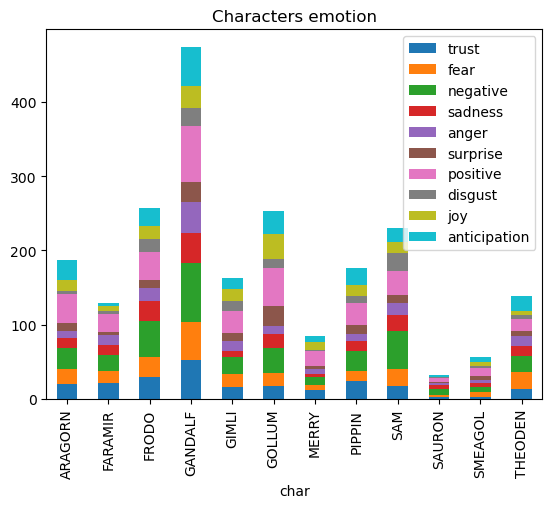

In [ ]:

char_emot_filtered = char_emot[char_emot['char'].isin(imp_char)]

char_emot_filtered.plot(x='char', kind='bar', stacked=True,
        title='Characters emotion')
plt.show()

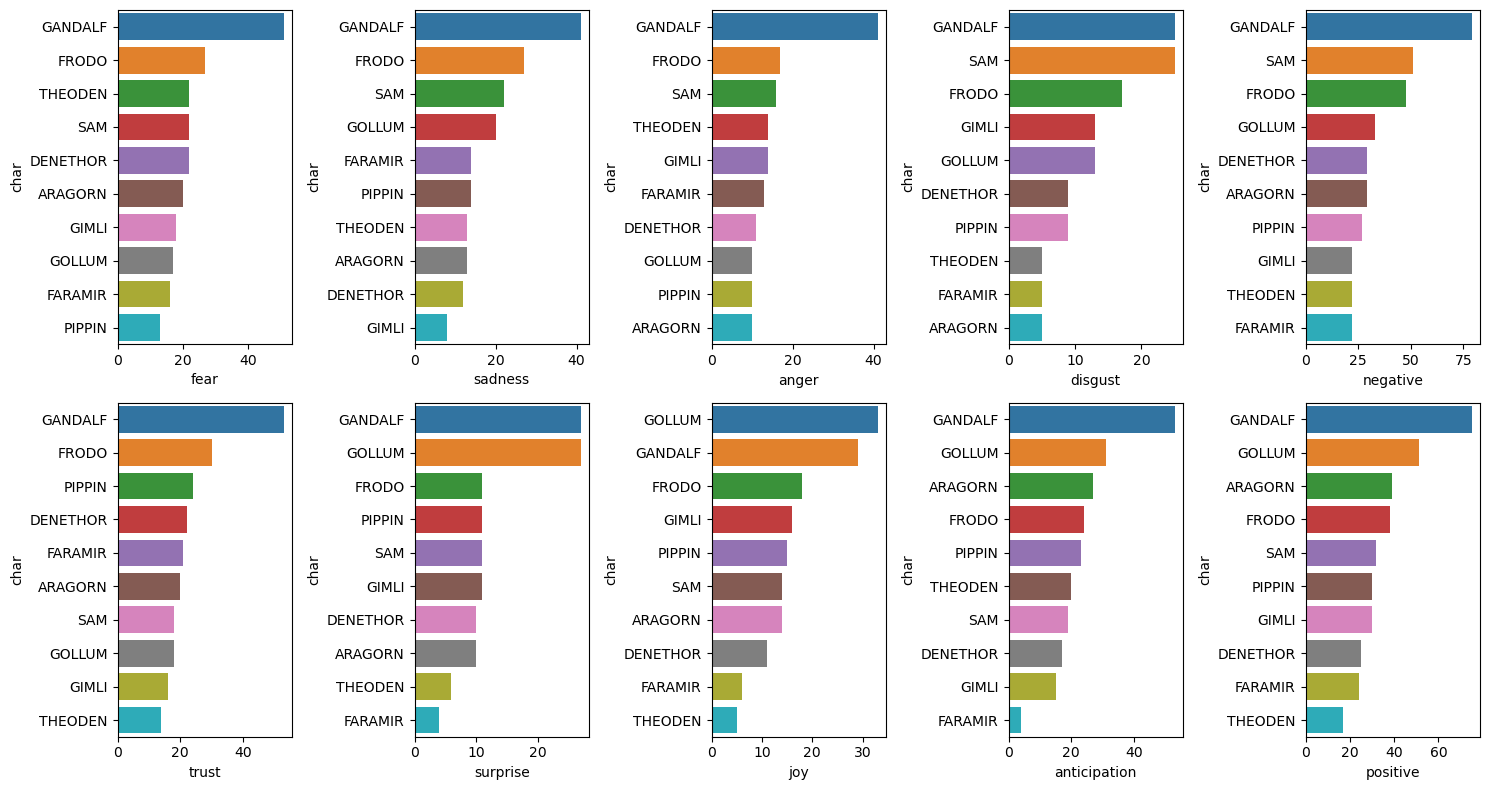

In [ ]:
em_list = ['fear',  'sadness', 'anger', 'disgust', 'negative', 
           'trust', 'surprise',  'joy', 'anticipation', 'positive']

def char_emot_subplot(data, x):
    plt.figure(figsize = (15, 8))
    for i in range(1, len(x)+1):
        plt.subplot(2, 5, i)
        data = data.sort_values(by=x[i-1], ascending=False)[:10]
        sns.barplot(x=data[x[i-1]], y=data.char)
    plt.tight_layout()
    plt.show()

char_emot_subplot(char_emot, em_list)

### AVG TF-IDF Score for dialog

In [ ]:
nan_indices = lotr_train.dialog.isna()
print(len(nan_indices))
lotr_train

1672


,char,dialog,word_len,character_len,stopword_count,verb_count,adj_count,propn_count,uinque_words,dialog_sentiment,...,trust,fear,negative,sadness,anger,surprise,positive,disgust,joy,anticipation
0,ORCS,"Grond, Grond, Grond, Grond!",4,29,0,0,0,4,2,0.000,...,0,0,0,0,0,0,0,0,0,0
1,FRODO,Smeagol?,1,10,0,0,0,0,1,0.000,...,0,0,0,0,0,0,0,0,0,0
2,SAM,Look!The gate.It's opening!I can see a way down.,8,49,2,1,0,0,8,0.125,...,0,0,0,0,0,0,0,0,0,0
3,PIPPIN,"Well, that's good news.",4,24,0,0,1,0,4,0.500,...,1,0,0,0,0,1,1,0,1,1
4,PIPPIN,Frodo.,1,11,0,0,0,1,1,0.000,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1667,EOWYN,Your words are poison.,4,27,2,0,0,0,4,-0.125,...,0,1,2,1,2,0,0,1,0,0
1668,SARUMAN,A new power is rising.Its victory is at hand.,9,46,4,1,1,0,8,1.500,...,1,0,0,0,0,0,1,0,1,1
1669,ORC,"Come on then , come on!",6,31,2,2,0,0,6,0.375,...,0,0,0,0,0,0,0,0,0,0
1670,SAM,Mr. Frodo!,2,11,0,0,0,2,2,0.000,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
def tf(document: List[str], term: str) -> float:

    term_freq = FreqDist()
    for word in document:
        if word.lower() == term:
            term_freq[term] += 1
    
    termfreq = (term_freq[term])/len(document)
    return termfreq


def idf(documents: List[List[str]], term: str) -> float:

    doc_count = 0
    for doc in documents:
        if term in doc:
            doc_count +=1
    if doc_count == 0:
        return 0
    
    idf = np.log(len(documents)/(doc_count))
    return idf


def tf_idf(all_documents: List[List[str]], document: List[str], term: str) -> float:

    term_freq = tf(document, term)
    inverse_df = idf(all_documents, term)
    tf_idf = term_freq*inverse_df

    return tf_idf


def avg_tf_idf(data, preprocessed):
    dialog_avg_tfidf = []
    for dialog in preprocessed:
        score = 0
        for term in dialog:
            p = tf_idf(data.dialog, dialog, term)
            score += p
        avg_tfidf = score/(len(dialog)+1)
        dialog_avg_tfidf.append(avg_tfidf)
    data["avg_tf-idf"] = dialog_avg_tfidf
    return data

lotr_train = avg_tf_idf(lotr_train, preprocessed_train)
lotr_test = avg_tf_idf(lotr_test, preprocessed_test)
lotr_train.head()

,char,dialog,word_len,character_len,stopword_count,verb_count,adj_count,propn_count,uinque_words,dialog_sentiment,...,fear,negative,sadness,anger,surprise,positive,disgust,joy,anticipation,avg_tf-idf
0,ORCS,"Grond, Grond, Grond, Grond!",4,29,0,0,0,4,2,0.000,...,0,0,0,0,0,0,0,0,0,0.000000
1,FRODO,Smeagol?,1,10,0,0,0,0,1,0.000,...,0,0,0,0,0,0,0,0,0,0.000000
2,SAM,Look!The gate.It's opening!I can see a way down.,8,49,2,1,0,0,8,0.125,...,0,0,0,0,0,0,0,0,0,1.286746
3,PIPPIN,"Well, that's good news.",4,24,0,0,1,0,4,0.500,...,0,0,0,0,1,1,0,1,1,1.231094
4,PIPPIN,Frodo.,1,11,0,0,0,1,1,0.000,...,0,0,0,0,0,0,0,0,0,0.000000


In [ ]:
lotr_train.to_csv('lotr_train.csv', index=False)
lotr_test.to_csv('lotr_test.csv', index=False)

In [ ]:
lotr_train = pd.read_csv('lotr_train.csv')
lotr_test = pd.read_csv('lotr_test.csv')

imp_char = ["FRODO", "SAM", "GANDALF", "PIPPIN", "MERRY", "GOLLUM", "GIMLI", "THEODEN", "FARAMIR", "SAURON", "ARAGORN", "SMEAGOL"]

## Character prediction
### Divide and conquer

In [ ]:
# Creating a common label for the characters not of interest. 
# Aware that this will impact the model, unsure if it would be positive or negative


def common_label(data):
    mask = data["char"].isin(imp_char)
    data.loc[~ mask, "char"] = "Rest"
    mask2 = data['char'] == 'Rest'
    data = data[~mask2]
    return data

lotr_train = common_label(lotr_train)
lotr_test = common_label(lotr_test)


def x_y_split(data):
    y_data = data['char']
    x_data = data.drop(columns=['char', 'dialog'])
    return x_data, y_data

lotr_train_X, lotr_train_Y = x_y_split(lotr_train)
lotr_test_X, lotr_test_Y = x_y_split(lotr_test)

def char_2_num(y_data):
    encoder = LabelEncoder()
    y_data = y_data.values.reshape(-1, 1)
    encoded_data = encoder.fit_transform(y_data)
    names = list(encoder.inverse_transform(np.unique(encoded_data)))
    print(names)
    print(np.unique(encoded_data))
    return encoded_data, names

lotr_train_Y, names = char_2_num(lotr_train_Y)
lotr_test_Y = char_2_num(lotr_test_Y)[0]


['ARAGORN', 'FARAMIR', 'FRODO', 'GANDALF', 'GIMLI', 'GOLLUM', 'MERRY', 'PIPPIN', 'SAM', 'SAURON', 'SMEAGOL', 'THEODEN']
[ 0  1  2  3  4  5  6  7  8  9 10 11]
['ARAGORN', 'FARAMIR', 'FRODO', 'GANDALF', 'GIMLI', 'GOLLUM', 'MERRY', 'PIPPIN', 'SAM', 'SAURON', 'SMEAGOL', 'THEODEN']
[ 0  1  2  3  4  5  6  7  8  9 10 11]


### Naive Benchmark model


In [ ]:
eval_methods = [ f1_score, precision_score, recall_score]

def naive_model(x_data, y_data):
    pred = np.random.randint(0, 12, size=len(x_data))
    print(classification_report(y_data, pred))
    print("Accuracy ", round(accuracy_score(y_data, pred), 4)) 
    
    for e in eval_methods:
        print(str(e.__name__), round(e(y_data, pred, average='weighted'), 4)) 
    return pred   

naive_predicitons = naive_model(lotr_test_X, lotr_test_Y)

              precision    recall  f1-score   support

           0       0.24      0.17      0.20        53
           1       0.00      0.00      0.00        14
           2       0.19      0.09      0.13        74
           3       0.20      0.12      0.15        76
           4       0.07      0.06      0.07        31
           5       0.05      0.06      0.05        32
           6       0.02      0.03      0.02        35
           7       0.08      0.07      0.07        44
           8       0.23      0.13      0.17        75
           9       0.00      0.00      0.00         2
          10       0.00      0.00      0.00        18
          11       0.06      0.08      0.07        36

    accuracy                           0.09       490
   macro avg       0.09      0.07      0.08       490
weighted avg       0.14      0.09      0.11       490

Accuracy  0.0939
f1_score 0.1101
precision_score 0.1395
recall_score 0.0939


### Random Forest Classifier


In [ ]:

def optimize_model_parameters(X_train, y_train, model, param_grid, cv=5):
 
    rfc = model()

    grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=cv, scoring='accuracy', n_jobs=-1, error_score='raise')
    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    print("Best Parameters:", best_params)
    print("Best Accuracy Score:", best_score)


    optimized = model(**best_params)
    optimized.fit(X_train, y_train)
    return optimized


param_grid = {
    'n_estimators': [15, 20, 25],
    'max_depth': [None, 3, 4, 5],
    'min_samples_split': [ 5, 10, 15],
    #'min_samples_leaf': [1, 2, 3, 4],
    'criterion': ['gini', 'entropy']
}

# Optimize parameters
optimized_rf = optimize_model_parameters(lotr_train_X, lotr_train_Y, RFC, param_grid)

Best Parameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_split': 5, 'n_estimators': 20}
Best Accuracy Score: 0.21438735177865614


In [ ]:
def evaluate_model(x_data, y_data, model):

    pred = model.predict(x_data)
    print(classification_report(y_data, pred))
    print("Accuracy ", round(accuracy_score(y_data, pred), 4)) 
    
    for e in eval_methods:
        print(str(e.__name__), round(e(y_data, pred, average='weighted'), 4)) 
    return pred  

rfc_predictions = evaluate_model(lotr_test_X, lotr_test_Y, optimized_rf) 

              precision    recall  f1-score   support

           0       0.12      0.15      0.13        53
           1       0.00      0.00      0.00        14
           2       0.19      0.27      0.22        74
           3       0.30      0.30      0.30        76
           4       0.10      0.06      0.08        31
           5       0.00      0.00      0.00        32
           6       0.10      0.11      0.11        35
           7       0.07      0.07      0.07        44
           8       0.21      0.19      0.20        75
           9       0.00      0.00      0.00         2
          10       0.33      0.11      0.17        18
          11       0.09      0.06      0.07        36

    accuracy                           0.16       490
   macro avg       0.13      0.11      0.11       490
weighted avg       0.16      0.16      0.16       490

Accuracy  0.1592
f1_score 0.1551
precision_score 0.1588
recall_score 0.1592


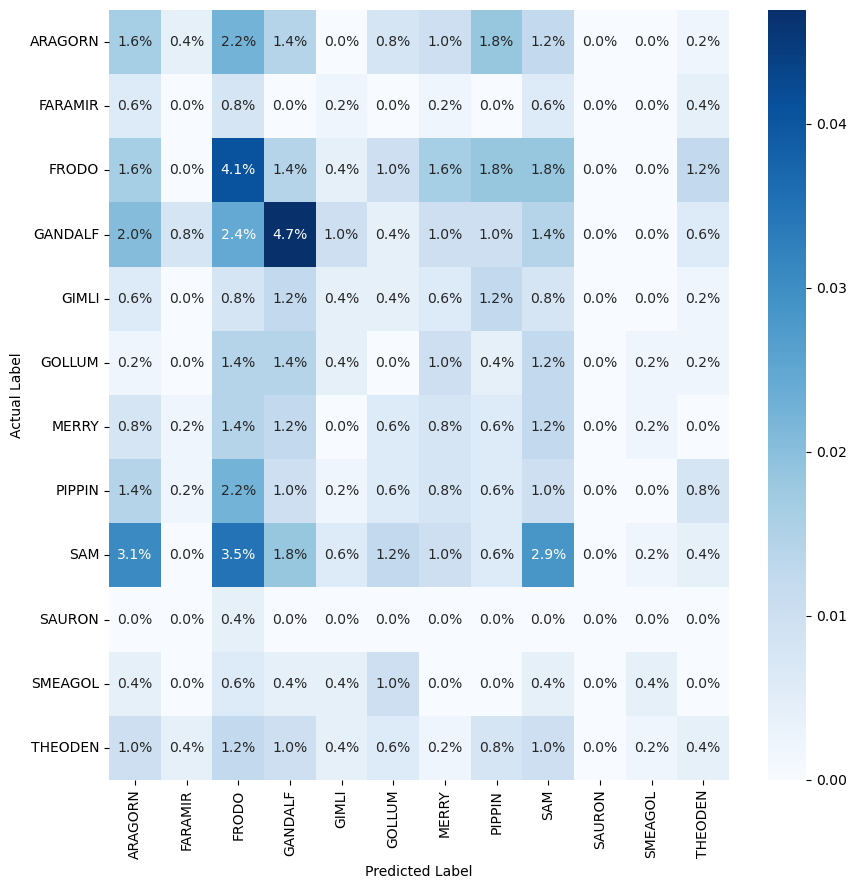

In [ ]:

def conf_matrix(y, pred):
    cm = confusion_matrix(y, pred)
    fig, ax = plt.subplots(figsize=(10,10)) 
    sns.heatmap(cm/np.sum(cm), annot=True, 
                fmt='.1%', cmap='Blues', ax=ax, 
                xticklabels=names, yticklabels=names)
    plt.xlabel('Predicted Label')
    plt.ylabel('Actual Label')
    plt.show()

conf_matrix(lotr_test_Y, rfc_predictions)

### ANN

In [ ]:

def std_scale(data):
    sc = StandardScaler()
    return sc.fit_transform(data)

lotr_train_X = std_scale(lotr_train_X)
lotr_test_X = std_scale(lotr_test_X)

In [ ]:

x_val_ann, x_test_ann, y_val_ann,  y_test_ann = TTS(lotr_test_X, lotr_test_Y, random_state=42, test_size=0.5)
train_Y_ANN = np.eye(12)[lotr_train_Y]
val_Y_ANN = np.eye(12)[y_val_ann] 

In [ ]:

def neural_net(x_train, y_train, x_val, y_val):
    classifier = Sequential()

    classifier.add(Dense(units=40, activation = 'relu', input_dim = 20))
    classifier.add(BatchNormalization())
    classifier.add(Dense(units=40, activation = 'selu'))
    classifier.add(Dropout(0.3))

    classifier.add(Dense(units=40, activation = 'LeakyReLU'))
    classifier.add(Dense(units=40, activation = 'gelu'))
    classifier.add(Dense(units=12, activation='softmax'))

    classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    print(classifier.summary())

    classifier.fit(x_train, y_train, epochs=250,  
                        batch_size=10, #callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.00001)],
                        validation_data=(x_val, y_val), verbose=1)
    return classifier
    
optimized_ann = neural_net(lotr_train_X, train_Y_ANN, x_val_ann, val_Y_ANN)

2024-04-15 12:22:37,027 : WARNING : From c:\Users\marcu\anaconda3\Lib\site-packages\keras\src\backend.py:873: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



2024-04-15 12:22:37,642 : WARNING : From c:\Users\marcu\anaconda3\Lib\site-packages\keras\src\optimizers\__init__.py:309: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 40)                840       
                                                                 
 batch_normalization (Batch  (None, 40)                160       
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 40)                1640      
                                                                 
 dropout (Dropout)           (None, 40)                0         
                                                                 
 dense_2 (Dense)             (None, 40)                1640      
                                                                 
 dense_3 (Dense)             (None, 40)                1640      
                                                        

2024-04-15 12:22:38,431 : WARNING : From c:\Users\marcu\anaconda3\Lib\site-packages\keras\src\utils\tf_utils.py:492: The name tf.ragged.RaggedTensorValue is deprecated. Please use tf.compat.v1.ragged.RaggedTensorValue instead.



2024-04-15 12:22:39,479 : WARNING : From c:\Users\marcu\anaconda3\Lib\site-packages\keras\src\engine\base_layer_utils.py:384: The name tf.executing_eagerly_outside_functions is deprecated. Please use tf.compat.v1.executing_eagerly_outside_functions instead.



116/116 [==============================] - 5s 8ms/step - loss: 2.5127 - accuracy: 0.1276 - val_loss: 2.4177 - val_accuracy: 0.1469
Epoch 2/250
116/116 [==============================] - 0s 3ms/step - loss: 2.3442 - accuracy: 0.1606 - val_loss: 2.3394 - val_accuracy: 0.1837
Epoch 3/250
116/116 [==============================] - 0s 4ms/step - loss: 2.2977 - accuracy: 0.1840 - val_loss: 2.3392 - val_accuracy: 0.1837
Epoch 4/250
116/116 [==============================] - 0s 3ms/step - loss: 2.2643 - accuracy: 0.2031 - val_loss: 2.3216 - val_accuracy: 0.1633
Epoch 5/250
116/116 [==============================] - 0s 3ms/step - loss: 2.2420 - accuracy: 0.1979 - val_loss: 2.3205 - val_accuracy: 0.1673
Epoch 6/250
116/116 [==============================] - 0s 4ms/step - loss: 2.2296 - accuracy: 0.2075 - val_loss: 2.3210 - val_accuracy: 0.1796
Epoch 7/250
116/116 [==============================] - 0s 4ms/step - loss: 2.2086 - accuracy: 0.2092 - val_loss: 2.3233 - val_accuracy: 0.2163
Epoch 8/250

16/16 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.11      0.17      0.14        53
           1       0.06      0.07      0.07        14
           2       0.14      0.19      0.16        74
           3       0.30      0.18      0.23        76
           4       0.05      0.03      0.04        31
           5       0.12      0.09      0.11        32
           6       0.08      0.11      0.09        35
           7       0.08      0.09      0.08        44
           8       0.18      0.11      0.13        75
           9       0.00      0.00      0.00         2
          10       0.30      0.17      0.21        18
          11       0.00      0.00      0.00        36

    accuracy                           0.12       490
   macro avg       0.12      0.10      0.10       490
weighted avg       0.14      0.12      0.13       490

Accuracy  0.1245
f1_score 0.1282
precision_score 0.1437
recall_score 0.1245


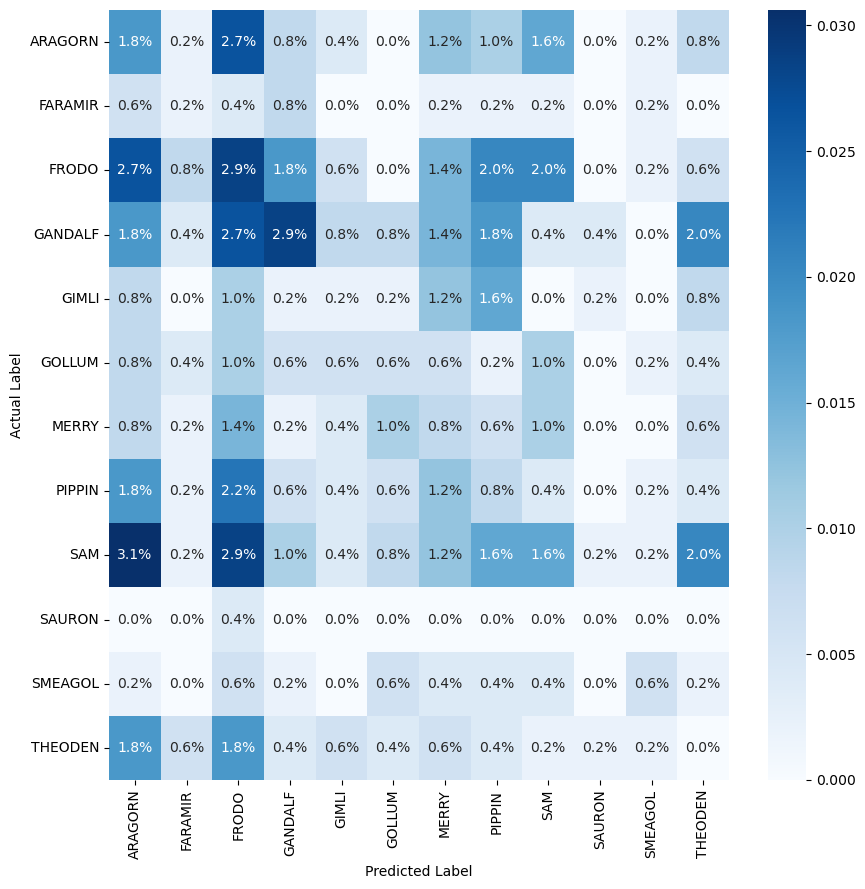

In [ ]:
def evaluate_ann(x_data, y_data, model):

    pred_matrix = model.predict(x_data)
    ann_prediction = np.argmax(pred_matrix, axis=1)
    print(classification_report(y_data, ann_prediction))
    print("Accuracy ", round(accuracy_score(y_data, ann_prediction), 4)) 
    
    for e in eval_methods:
        print(str(e.__name__), round(e(y_data, ann_prediction, average='weighted'), 4)) 
    return ann_prediction  


ann_prediction = evaluate_ann(lotr_test_X, lotr_test_Y, optimized_ann)
conf_matrix(lotr_test_Y, ann_prediction)